# Segmentation Model

In [1]:
# Prerequisites
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from segmentation_dataset import SegmentationDataset
import segmentation_models_pytorch as smp 



/home/jari/MyGithub/ML_2D_Computer_Vision_Experiments/semantic_segmentation_satellite_images/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check Running Environment

In [2]:
# Check if notebook being run in Colab or locally  
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False
print (f'Running in Colab: {IN_COLAB}')

# Check if GPU is available
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using ", DEVICE)

Running in Colab: False
Using  cuda


### Set Hyperparameters

In [3]:
NR_EPOCHS = 50
BATCH_SIZE = 4

### Set 'train' and 'val' Datasets & Dataloaders

In [4]:
if IN_COLAB:
    pass
else:
    train_data_path = "data/processed/train"
    val_data_path = "data/processed/val"
    test_data_path = "data/processed/test"


train_dataset = SegmentationDataset(path_name=train_data_path)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataset = SegmentationDataset(path_name=val_data_path)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Define Model

In [5]:
model = smp.FPN( #  Feature Pyramid Network
    encoder_name = "se_resnext50_32x4d", # Encoder - ResNeXt-50
    encoder_weights="imagenet", # Pretrained weights for encoder
    classes=6, # Number of output classes
    activation="sigmoid" #
) 

model.to(DEVICE)   # Move model to GPU if available

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Adam optimizer

criterion = nn.CrossEntropyLoss() # Cross-entropy loss
# criterion = smp.losses.DiceLoss(mode='multiclass') # Dice loss

### Training Loop

In [6]:
train_losses = []
val_losses = []

for epoch in range(NR_EPOCHS):

    # Training Phase
    model.train()
    running_train_loss = 0
    running_val_loss = 0

    for i, data in enumerate(train_dataloader):
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)

        # Reset gradients
        optimizer.zero_grad()

        # Forward Pass
        output = model(image.float())

        # Calculate losses
        train_loss = criterion(output.float(), mask.long())

        # Back propagation
        train_loss.backward()
        optimizer.step()  # Update weights

        running_train_loss += train_loss.item()

    train_losses.append(running_train_loss)

    # Validation Phase
    model.eval()
    for i, data in enumerate(val_dataloader):
        image_i, mask_i = data
        image = image_i.to(DEVICE)
        mask = mask_i.to(DEVICE)

        # Forward Pass
        output = model(image.float())

        # Calculate losses
        val_loss = criterion(output.float(), mask.long())
        running_val_loss += val_loss.item()

    val_losses.append(running_val_loss)

    print(f"Epoch: {epoch}: Train Loss: {np.median(running_train_loss)}, Val Loss: {np.median(running_val_loss)}")


Epoch: 0: Train Loss: 215.07346761226654, Val Loss: 11.478332757949829
Epoch: 1: Train Loss: 198.18486106395721, Val Loss: 11.159059405326843
Epoch: 2: Train Loss: 190.6931587457657, Val Loss: 10.659957885742188
Epoch: 3: Train Loss: 186.4621922969818, Val Loss: 10.647778391838074
Epoch: 4: Train Loss: 184.33936417102814, Val Loss: 10.662045001983643
Epoch: 5: Train Loss: 182.80574929714203, Val Loss: 10.603627800941467
Epoch: 6: Train Loss: 181.42306697368622, Val Loss: 10.601954936981201
Epoch: 7: Train Loss: 180.44062209129333, Val Loss: 10.629018306732178
Epoch: 8: Train Loss: 179.79058051109314, Val Loss: 10.572341561317444
Epoch: 9: Train Loss: 179.53445076942444, Val Loss: 10.566187977790833
Epoch: 10: Train Loss: 178.77402234077454, Val Loss: 10.640004754066467
Epoch: 11: Train Loss: 178.1222791671753, Val Loss: 10.520795226097107
Epoch: 12: Train Loss: 177.66884624958038, Val Loss: 10.576687812805176
Epoch: 13: Train Loss: 180.19193184375763, Val Loss: 10.612848043441772
Epoch

### Visualize

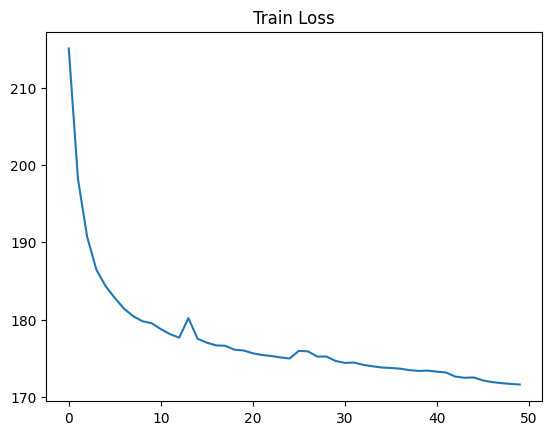

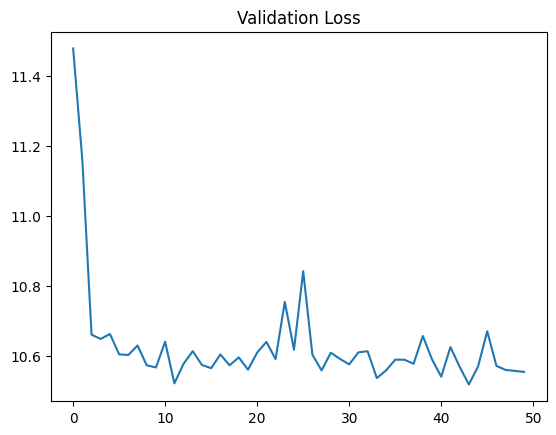

In [7]:
sns.lineplot(x = range(len(train_losses)), y= train_losses).set(title='Train Loss')
plt.show()
sns.lineplot(x = range(len(train_losses)), y= val_losses).set(title='Validation Loss')
plt.show()

### Save Model

In [8]:
torch.save(model.state_dict(), f'models/FPN_epochs_{NR_EPOCHS}_crossentropy_state_dict.pth')